In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fft import fft, ifft
from scipy.optimize import line_search
from tensorflow.python import tf2
from keras.datasets import mnist
from scipy.linalg import convolution_matrix
from PIL import Image, ImageOps
import time

In [19]:
K = np.diag(np.array([1,2,3]))
M = np.diag(np.array([7,8,9]))
N = np.array([[1,2,3],[4,5,6],[7,8,9]])
NtN = N.T @ N
print(N@K)

[[ 1  4  9]
 [ 4 10 18]
 [ 7 16 27]]


## Forward-Backward
We will use FB to minimize the function
$$f(x) + g(x) = \frac{1}{2 \lambda}\|Ax-y\|_2^2 + \|x\|_1$$
Let us for the time being omit the $\frac{1}{2\lambda}$ term. For the Forward-Backward method, we require $\nabla f$.
We can find this using directional derivatives. Rewriting, we have
$$f(x) = \|Ax-y\|_2^2 = (Ax-y)^T(Ax-y) = x^TA^TAx - 2x^TA^Ty + y^Ty.$$
The directional derivative of $f$ along $v$ is
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h}$$
$$= \lim_{h \xrightarrow{} 0} \frac{(x+hv)^TA^TA(x+hv) - 2(x+hv)^TA^Ty + y^Ty - x^TA^TAx + 2x^TA^Ty - y^Ty}{h}$$
$$
= \lim_{h \xrightarrow{} 0} 2x^TA^tAv + hv^TA^TAv - 2v^TA^Ty = v^T(2A^TAx - 2A^Ty).
$$
However, from Taylor expansion we also have
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h} \approx \lim_{h \xrightarrow{} 0} \frac{f(x) + hv^T\nabla f(x) - f(x)}{h} = v^T \nabla f(x).$$
Hence from the previous equation we also have
$$\nabla_v f(x) = v^T(2A^TAx - 2A^Ty) = v^T \nabla f(x),$$
and so
$$\nabla f(x) = 2A^TAx - 2A^Ty.$$
Now, the Forward-Backward Algorithm is given to us as
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla f(x_n)\right).$$
In the case that $R(x) = \|x\|_1$, we have
$$prox_{\gamma R}(x) = sign(x) \max{(|x|-\gamma,0)}.$$
Hence, for our current loss function, we have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{\lambda}\left(A^TAx - A^Ty\right)\right),$$
with $prox$ as above.

100


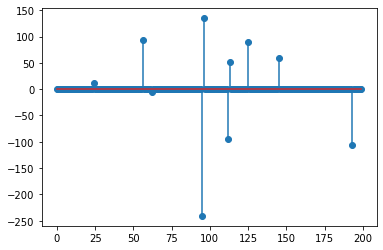

In [105]:
def gauk(sz,sg):     #function that generates a discrete gaussian kernel of size = sz with mean 0 and sigma = sg
    discr = np.linspace(-(sz - 1) / 2., (sz - 1) / 2., sz)
    g_discr = np.exp(-0.5 * np.square(discr) / (2*sg**2))
    return g_discr / (np.sqrt(2 * np.pi) * sg)
#Initializations
samples = 200;
#Initialize some random sparse solution
x0 = np.zeros((samples,1))
p = np.random.permutation(samples)
nz = 10
x0[p[:nz]] = 100*np.random.randn(nz,1)
x0 = np.reshape(x0,-1)
#Generate gaussian kernel
k = gauk(101,10)
#generate gaussian toeplitz matrix
A = convolution_matrix(k, 200, mode='valid')
y = A@x0
features = np.size(y);
print(features)
plt.stem(x0)
plt.show()

In [110]:
#Create array of regularization parameters
lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/10, np.max(np.abs(A.T@y))/2, np.max(np.abs(A.T@y))])
lamsz = np.size(lamb)
lamb

array([0.07579477, 0.37897387, 1.89486937, 3.78973874])

In [95]:
#np.savetxt("x0.csv", x0, delimiter=",")
#np.savetxt("y0.csv", y, delimiter=",")
#np.savetxt("A.csv", A, delimiter=",")
#my_data = np.genfromtxt('x0.csv', delimiter=',')
#np.linalg.norm(x0 - my_data)
#np.size(np.dot(np.matmul(A.T,A),x),0)
k

array([7.70139775e-05, 9.86409936e-05, 1.25711165e-04, 1.59411185e-04,
       2.01137134e-04, 2.52519111e-04, 3.15445817e-04, 3.92088246e-04,
       4.84921456e-04, 5.96743237e-04, 7.30688275e-04, 8.90236299e-04,
       1.07921255e-03, 1.30177882e-03, 1.56241336e-03, 1.86587787e-03,
       2.21717010e-03, 2.62146062e-03, 3.08401294e-03, 3.61008621e-03,
       4.20482070e-03, 4.87310667e-03, 5.61943797e-03, 6.44775271e-03,
       7.36126397e-03, 8.36228448e-03, 9.45205003e-03, 1.06305470e-02,
       1.18963503e-02, 1.32464773e-02, 1.46762663e-02, 1.61792839e-02,
       1.77472691e-02, 1.93701196e-02, 2.10359242e-02, 2.27310459e-02,
       2.44402571e-02, 2.61469266e-02, 2.78332585e-02, 2.94805774e-02,
       3.10696560e-02, 3.25810768e-02, 3.39956186e-02, 3.52946591e-02,
       3.64605791e-02, 3.74771590e-02, 3.83299530e-02, 3.90066308e-02,
       3.94972738e-02, 3.97946170e-02, 3.98942280e-02, 3.97946170e-02,
       3.94972738e-02, 3.90066308e-02, 3.83299530e-02, 3.74771590e-02,
      

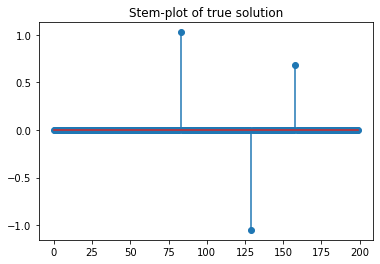

In [5]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.stem(x0)
ax.set_title('Stem-plot of true solution')
plt.savefig('foo.png')

In [64]:
def errL2(A,x,y):   #Return L2 error of Ax-y
    dif = A@x - y
    return dif.T @ dif

In [65]:
def funcreg(A,x,y,lam):    #Return f(x)+g(x)
    dif = A@x - y
    fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
    return fxgx

In [66]:
#Implement thresh/prox function for g(x) = ||1||_1
def prox(x,lam):
    return np.sign(x) * np.maximum(np.abs(x)-lam*np.ones(np.size(x)),0)

In [67]:
def GradF(A,x,y):                   #Calculate gradient of ||Ax-y||_2^2
    return (((A.T @ A) @ x) - A.T @ y)

In [68]:
def SubdifTest(A,x,y,lam):          #Subdifferential Test to check for correct solution
    gradf = GradF(A,x,y)/lam
    return max(abs(gradf))

Time for 5000 iterations: 1.4846148490905762 seconds
Subdifferential: 1.0172522938602258


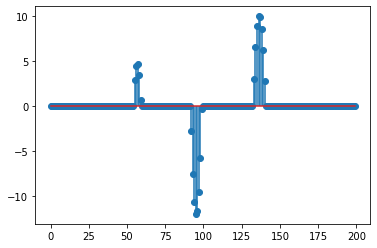

Time for 5000 iterations: 1.4911093711853027 seconds
Subdifferential: 0.43692672556585466


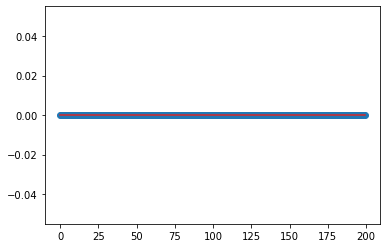

Time for 5000 iterations: 1.4061024188995361 seconds
Subdifferential: 0.08738534511317093


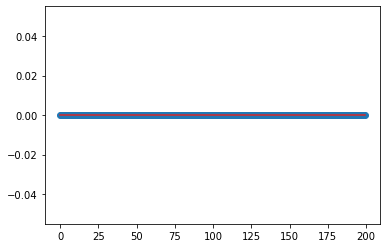

Time for 5000 iterations: 1.3570985794067383 seconds
Subdifferential: 0.04369267255658547


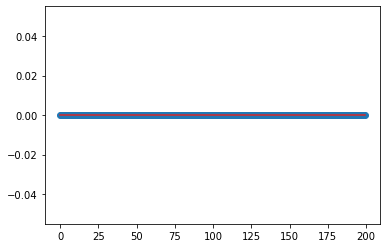

Text(0.5, 1.0, 'ln(G(x)) vs Iterations)')

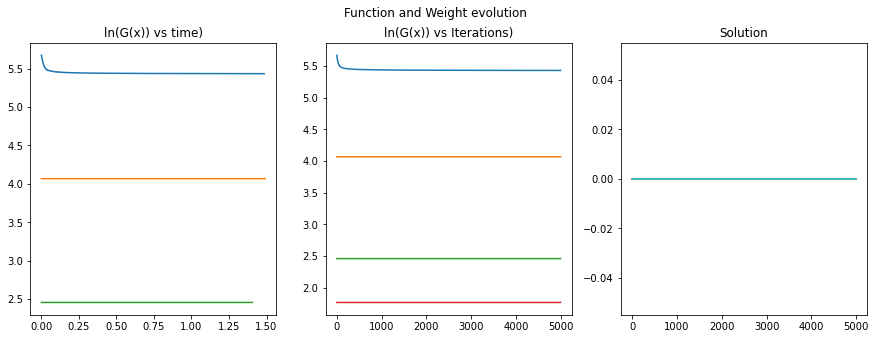

In [106]:
#Implement Forward Backward alg
#initialize x_0 = 0
x = np.zeros(samples)
niter = 5000
funcvec_fb = np.zeros((lamsz,niter))
omg = .1/np.linalg.norm(A)
time_fb = np.zeros((lamsz,niter))
for l in range(lamsz):
    lam = lamb[l]
    xtemp = np.zeros((samples,niter))
    x = np.zeros(samples)
    start = time.time()
    for i in range(niter):
        #print("Iteration", i)
        x = prox(x - (omg/lam)*(np.dot(np.matmul(A.T,A),x) - np.dot(A.T,y)),omg)
        #fftx = np.fft.fft(x,10000)
        #fftdiff = fftk * fftx - ffty
        #gradconv = np.fft.ifft(fftkc * fftdiff,samples)
        #x = prox(x - (omg/lam)*gradconv,omg)
        xtemp[:,i] = x
        funcvec_fb[l,i] = funcreg(A,x,y,lam)
        time_fb[l,i] = time.time() - start

    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(x)
    plt.show()
    
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs[0].plot(time_fb[0,:], np.log(funcvec_fb[0,:].T));
axs[0].plot(time_fb[1,:], np.log(funcvec_fb[1,:].T));
axs[0].plot(time_fb[2,:], np.log(funcvec_fb[2,:].T));
axs[0].set_title('ln(G(x)) vs time)')
axs[2].plot(xtemp.T);
axs[2].set_title('Solution')
axs[1].plot(np.log(funcvec_fb.T));
axs[1].set_title('ln(G(x)) vs Iterations)')

## Gradient Descent
Now, by Theorem 2 in the paper, we have that $(\mathcal{P}_\lambda)$ is equivalent to
$$\min_{v \in \mathbb{R}^k} f(v) \triangleq \min_{u \in \mathbb{R}^n} G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right).$$

We will use $h(v \odot v) = \|v\|_2^2$ and $L$ as above. By Corollary 1, $u$ solves
$$(diag(v) X^TX diag(v) + \lambda I)u = v \odot_{\mathcal{G}} (X^Ty),$$
so that
$$u = (diag(v) X^TX diag(v) + \lambda I)^{-1} (v \odot_{\mathcal{G}} (X^Ty)).$$

In order to solve $\min_{v \in \mathbb{R}^k} f(v)$ by Gradient Descent, we find $\nabla f = \frac{\partial f}{\partial v}:$
$$\frac{\partial f}{\partial v} = \partial_v G(u,v) = v + \frac{1}{\lambda} \partial_v L.$$ Now, using chain rule, we have that, denoting $\omega = (v \odot_{\mathcal{G}} u),$
$$\frac{\partial L}{\partial v_i} = \nabla L \cdot \frac{\partial \omega}{\partial v_i},$$
that is
$$\frac{\partial L}{\partial v_i} = \frac{1}{\lambda}\left(X^TX (v \odot_{\mathcal{G}} u) - X^Ty \right) \cdot u',$$
where $u' = (0, \ldots, u_g, \ldots, 0)$. The above can also be reformulated (as per Proposition 3) as
$$\nabla f = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right)$$
We can now apply Gradient Descent.

In [107]:
def find_u(X,y,v,lam): 
    invm =  np.diag(v) @ (X.T @ (X @ np.diag(v))) + lam * np.eye(np.size(v))
    return np.linalg.inv(invm) @ (np.multiply(v,X.T @ y))

In [108]:
def Gradf(X,y,v,lam):
    u = find_u(X,y,v,lam)
    tempvec = v + (1/lam) * ( u * (X.T @ (X @ (v*u)) - X.T @ y))
    return tempvec

Time for 5000 iterations: 34.56925964355469 seconds
Subdifferential: 1.0029580460570595


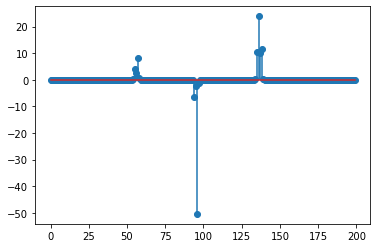

Time for 5000 iterations: 32.16108059883118 seconds
Subdifferential: 0.43692672556585466


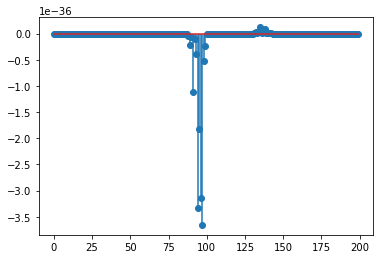

Time for 5000 iterations: 34.580793380737305 seconds
Subdifferential: 0.08738534511317093


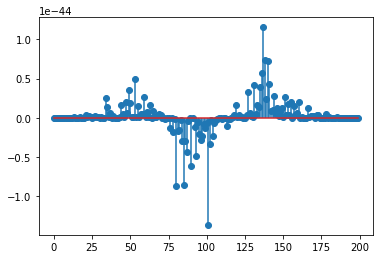

KeyboardInterrupt: 

In [109]:
step = 0.01
niter = 5000
funcvec_gdu = np.zeros((lamsz,niter))
#v = np.zeros(samples)
xtemp2 = np.zeros((samples,niter))
time_gdu = np.zeros((lamsz,niter))

for l in range(lamsz):
    lam = lamb[l]
    v = np.random.randn(samples)
    start = time.time()
    for i in range(niter):
        #print("Iteration", i)
        grad = Gradf(A,y,v,lam)
        #grad = Gradf_conv(A,fftk,fftkc,y,v,lam)
        v = v - step*grad
        x = v * find_u(A,y,v,lam)
        #x = v * find_u_conv(fftk,fftkc,ffty,v,lam)
        xtemp2[:,i] = x
        funcvec_gdu[l,i] = funcreg(A,x,y,lam)
        time_gdu[l,i] = time.time() - start
        
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(x)
    plt.show()

fig, axs2 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs2[1].plot(np.log(funcvec_gdu.T));
axs2[1].set_title('ln(G(x)) vs iterations')
axs2[0].plot(time_gdu[0,:],funcvec_gdu[0,:].T);
axs2[0].plot(time_gdu[1,:],funcvec_gdu[1,:].T);
axs2[0].plot(time_gdu[2,:],funcvec_gdu[2,:].T);
axs2[0].set_title('ln(G(x)) vs time)')
axs2[2].plot(xtemp2.T);
axs2[2].set_title('Solution')
    


## Gradient Descent on $u$ and $v$

Now we will compare convergence when using the SGD algorithm, as opposed to Gradient Descent.

Recall from above that if
$$G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right) = \frac{1}{2}\|v\|_2^2 + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right),$$ 
with L the square-loss function, then we have
$$\partial_v G(u,v) = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$
Similarly, we have
$$\partial_u G(u,v) = u + \frac{1}{\lambda} \left( v \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$

Now our update step will look like
$$\begin{cases}
u_{k+1} = u_k - \gamma_k\partial_u G(u,v) \\
v_{k+1} = v_k - \gamma_k\partial_v G(u,v)
\end{cases}$$

Regarding which stepsize, $\omega_k$, to use: we can either update $\omega_k$ using Backtracking Line Search or using the Barzilai-Borwein algorithm.

[1]Gabriel Peyré. Mathematical Foundations of Data Sciences, 2021.

In [16]:
def Gux(u,v,X,y,lam):             #Our objective function G(u,v)
    dif = X@(u * v) - y
    return (v.T @ v)/2 + (u.T @ u)/2 + (1/lam)*(dif.T @ dif)

In [17]:
def GnabV(u,v,X,y,lam):
    return v + (1/lam)*u*((X.T @ X)@(v*u) - X.T @ y)

In [18]:
def GnabU(u,v,X,y,lam):
    return u + (1/lam)*v*((X.T @ X)@(v*u) - X.T @ y)

In [19]:
def LineSearchU(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for u minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabU(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

In [20]:
def LineSearchV(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for v minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabV(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux(u,(v - omg*grad),X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

Time for 10000 iterations: 13.656429052352905 seconds
Subdifferential: 1.0001237597251798


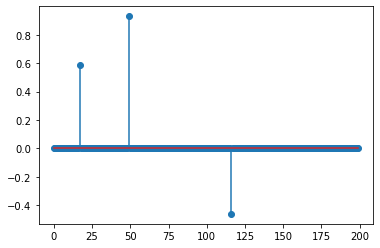

Time for 10000 iterations: 11.891290426254272 seconds
Subdifferential: 1.0003181676937123


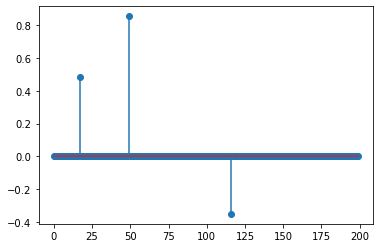

Time for 10000 iterations: 10.92197299003601 seconds
Subdifferential: 1.000420946595316


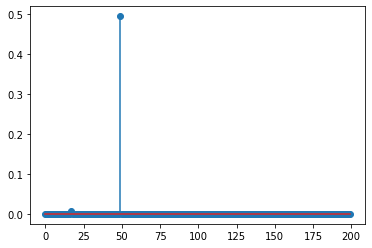

Time for 10000 iterations: 25.97619605064392 seconds
Subdifferential: 0.941536647430708


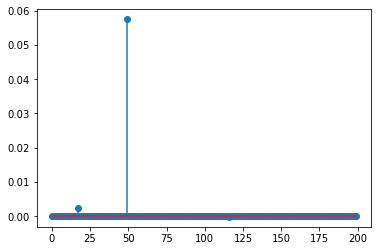

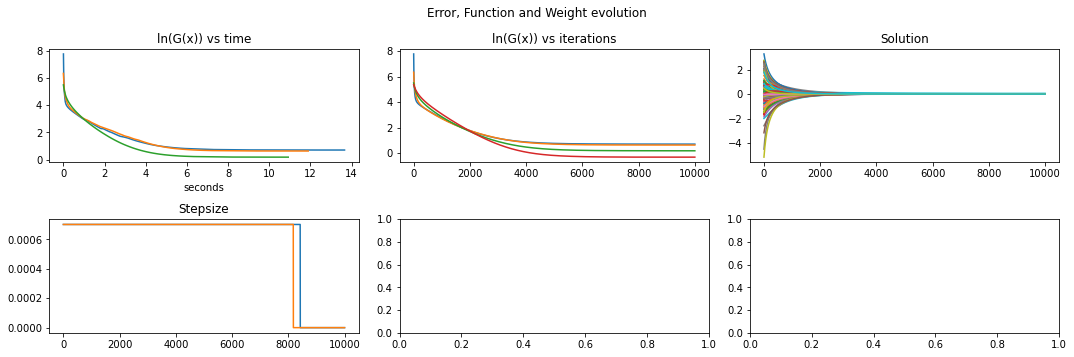

In [49]:
#Do gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 10000
xtemp3 = np.zeros((samples,niter))
funcvec_gda = np.zeros((lamsz,niter))
steparr = np.zeros((2,niter))
time_gda = np.zeros((lamsz,niter))
for l in range(lamsz):
    u = np.random.randn(samples)
    v = np.random.randn(samples)
    lam = lamb[l]
    start = time.time()
    for i in range(niter):
        #rndindx = np.random.randint(0, samples, 1)[0]
        #ch_sample = A[:,rndindx].reshape(-1,1)
        gradu = GnabU(u,v,A,y,lam)
        gradv = GnabV(u,v,A,y,lam)
        stepu = LineSearchU(u,v,A,y,lam)
        stepv = LineSearchV(u,v,A,y,lam)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
        u = u - stepu*gradu
        v = v - stepv*gradv
        x = u * v
        xtemp3[:,i] = x
        funcvec_gda[l,i] = funcreg(A,x,y,lam)
        time_gda[l,i] = time.time() - start
        #print(stepu)
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(x)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_gda[0,:],np.log(funcvec_gda[0,:].T));
axs3[0,0].plot(time_gda[1,:],np.log(funcvec_gda[1,:].T));
axs3[0,0].plot(time_gda[2,:],np.log(funcvec_gda[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,0].set_xlabel('seconds')
axs3[0,1].plot(np.log(funcvec_gda.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')
fig.tight_layout(pad=1.0)

In [22]:
def BBstep(xt,xtm1,gradt,gradtm1):    #Function for Barzilai-Borwein stepsize
    eps = 10**(-30)
    st = xt - xtm1
    yt = gradt - gradtm1
    return (st.T @ st) / (abs((st.T @ yt)) + eps)

Time for 5000 iterations: 6.830073595046997 seconds
Subdifferential: 1.000000000000008


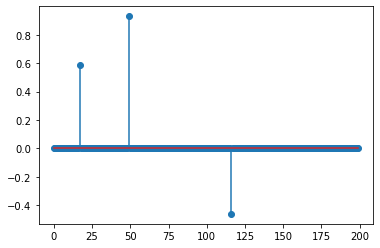

Time for 5000 iterations: 7.190794467926025 seconds
Subdifferential: 1.0000000000000002


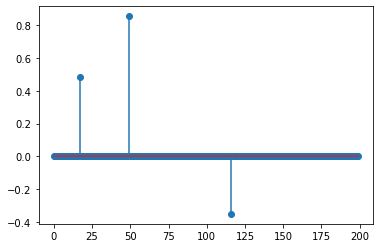

Time for 5000 iterations: 7.011738061904907 seconds
Subdifferential: 1.0000000000000002


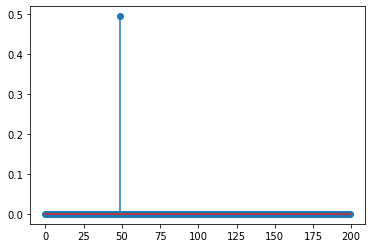

Time for 5000 iterations: 7.3638739585876465 seconds
Subdifferential: 0.9999999834819211


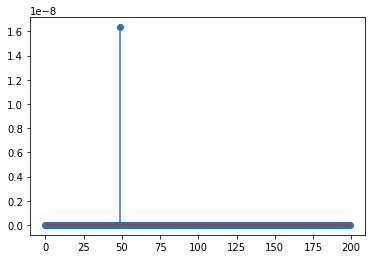

Text(0.5, 1.0, 'Stepsize')

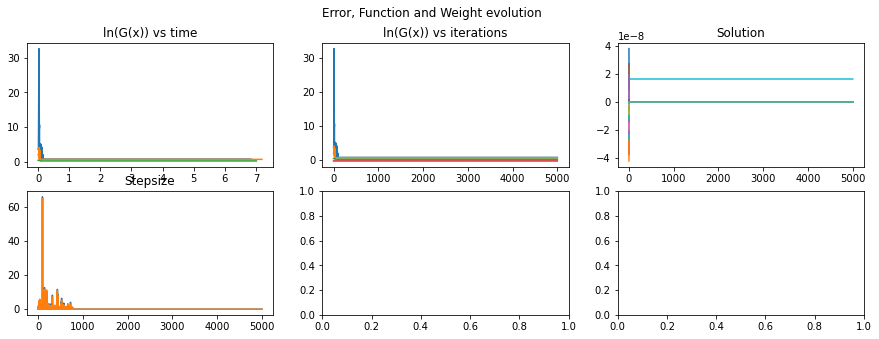

In [50]:
#Do gradient descent with step chosen using Barzilai-Borwein
step = 0.001
niter = 5000
xtemp3 = np.zeros((samples,niter))
funcvec_gdb = np.zeros((lamsz,niter))
steparr = np.zeros((2,niter))
uold = u
vold = v
time_gdb = np.zeros((lamsz,niter))

for l in range(lamsz):
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    lam = lamb[l]
    start = time.time()
    for i in range(niter):
        #rndindx = np.random.randint(0, samples, 1)[0]
        #ch_sample = A[:,rndindx].reshape(-1,1)
        gradu = GnabU(u,v,A,y,lam)
        gradv = GnabV(u,v,A,y,lam)
        #stepu = LineSearchU(u,v,ch_sample,y,lam)
        #stepv = LineSearchV(u,v,ch_sample,y,lam)
        stepu = .1/np.linalg.norm(A)
        stepv = .1/np.linalg.norm(A)
        if(i > 0):
            stepu = BBstep(u,uold,GnabU(u,v,A,y,lam),GnabU(uold,vold,A,y,lam))
            stepv = BBstep(v,vold,GnabV(u,v,A,y,lam),GnabV(uold,vold,A,y,lam))
    
        steparr[0,i] = stepu
        steparr[1,i] = stepv
        uold = u
        vold = v
        u = u - stepu*gradu
        v = v - stepv*gradv
        x = u * v
        xtemp3[:,i] = x
        funcvec_gdb[l,i] = funcreg(A,x,y,lam)
        time_gdb[l,i] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(x)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(np.log(funcvec_gdb.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,0].plot(time_gdb[0,:],np.log(funcvec_gdb[0,:].T));
axs3[0,0].plot(time_gdb[1,:],np.log(funcvec_gdb[1,:].T));
axs3[0,0].plot(time_gdb[2,:],np.log(funcvec_gdb[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [27]:
#Now try with real data - load MNIST digits
#(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Stochastic Gradient Descent
Now, note that
$$\frac{1}{2}\|Ax-y\|_2^2 = \frac{1}{2}\sum^m_{i=1} \left(\langle A_i, x \rangle - y_i \right)^2 = \frac{1}{2}\sum^m_{i=1} Q_i = \frac{1}{2}\sum^m_{i=1} L_i^2 $$

Thus, a partial derivative w.r.t $x_i$ is just
$$\nabla Q_i(x) = L_i \cdot A_i^T,$$

where $A_i$ is the $i$-th row of the matrix $A$, corresponding to the $i$-th sample.

Furrthermore, if we have that $x = u \odot v,$ then by chain rule we have
$$\nabla_u Q_i(x) = L_i \cdot A_i^T \odot v.$$
$$\nabla_v Q_i(x) = L_i \cdot A_i^T \odot u.$$

In [24]:
#Check that sum of gradient is gradient of the sum
x = np.zeros(samples)
diff = A@x-y
grad = np.zeros(samples)
for i in range(features):
    grad = grad + diff[i] * A[i,:].T
    
print(np.linalg.norm(grad - GradF(A,x,y)))

8.516947624188251e-14


In [24]:
print(np.size(A,0))

100


In [25]:
def SGnabV(u,v,X,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    features = np.size(X,0)
    Li = Xi @ (u*v) - y[indx]
    return v + (1/lam)*features*u*(Xi @ (u*v) - y[indx])*Xi.T
    #return lam*v + features*u*(Xi @ (u*v) - y[indx])*Xi.T

In [26]:
def SGnabU(u,v,X,y,lam,indx):             #Stochastic Gradient for U
    Xi = X[indx,:]
    features = np.size(X,0)
    Li = Xi @ (u*v) - y[indx]
    return u + (1/lam)*features*v*(Xi @ (u*v) - y[indx])*Xi.T
    #return lam*u + features*u*(Xi @ (u*v) - y[indx])*Xi.T

Time for 5000 iterations: 0.5115456581115723 seconds
Final f(x)+g(x): 2.011846575382221
Subdifferential: 0.950905351609886


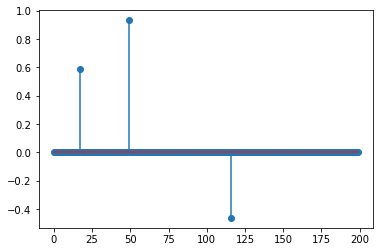

Time for 5000 iterations: 0.5781457424163818 seconds
Final f(x)+g(x): 3.1820201581575405
Subdifferential: 4.574336013838654


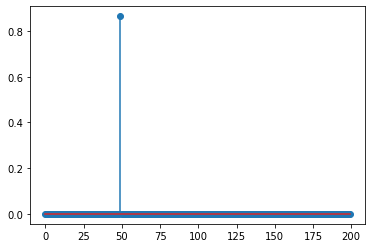

Time for 5000 iterations: 0.6020407676696777 seconds
Final f(x)+g(x): 1.4373795209597933
Subdifferential: 1.9999999177113312


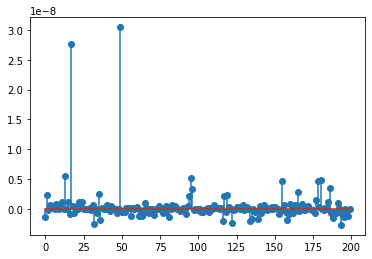

Time for 5000 iterations: 0.5250353813171387 seconds
Final f(x)+g(x): 0.718689834447172
Subdifferential: 0.9999999998041784


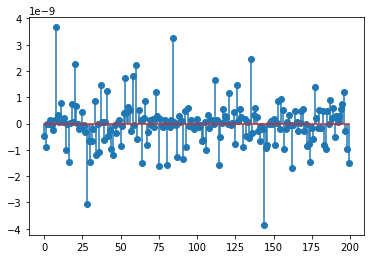

Text(0.5, 1.0, 'Stepsize')

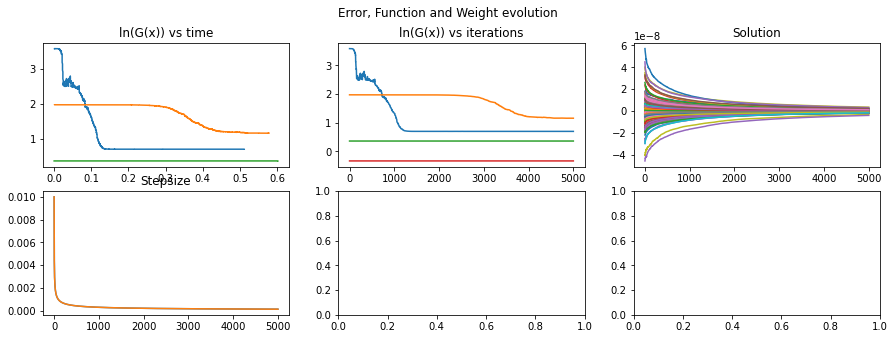

In [89]:
#Do SGD with decaying stepsize omg_k = omg_0 / (1 + k/10)
step = 0.001
niter = 5000
xtemp3 = np.zeros((samples,niter))
funcvec_sgd = np.zeros((lamsz,niter))
time_sgd = np.zeros((lamsz,niter))
steparr = np.zeros((2,niter))
for l in range(lamsz):
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    lam = lamb[l]
    start = time.time()
    for i in range(niter):
        rndindx = np.random.randint(features)
        #ch_sample = A[:,rndindx].reshape(-1,1)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        stepu = 0.01/(1+i)**0.51
        stepv = 0.01/(1+i)**0.51
        steparr[0,i] = stepu
        steparr[1,i] = stepv
        u = u - stepu*gradu
        v = v - stepv*gradv
        x = u * v
        xtemp3[:,i] = x
        funcvec_sgd[l,i] = funcreg(A,x,y,lam)
        #print(stepu)
        time_sgd[l,i] = time.time() - start
    
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_sgd[l,-1])
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_sgd[0,:],np.log(funcvec_sgd[0,:].T));
axs3[0,0].plot(time_sgd[1,:],np.log(funcvec_sgd[1,:].T));
axs3[0,0].plot(time_sgd[2,:],np.log(funcvec_sgd[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_sgd.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [28]:
def SGD_BB_k(xt,xtm1,gradt,gradtm1,Ckm1,phik,k,epoch_sz):    #Smoothing technique for the SGD BB step
    st = xt - xtm1
    yt = gradt - gradtm1
    bbk = (1/epoch_sz)*(st.T @ st) / abs((st.T @ yt))
    Ckopt = (bbk * phik) ** (1/(k-1))
    Ckm1opt = Ckm1 ** ((k-2)/(k-1))
    return Ckm1opt * Ckopt

Time for 2000 iterations: 11.22983431816101 seconds
Final f(x)+g(x): 2.011439583285079
Subdifferential: 1.0140053994154437


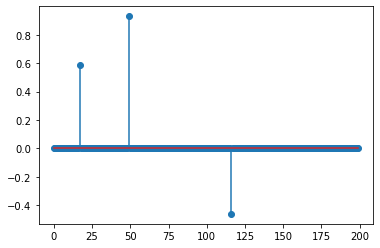

Time for 2000 iterations: 11.408308506011963 seconds
Final f(x)+g(x): 1.8692549761338961
Subdifferential: 1.0140610926121352


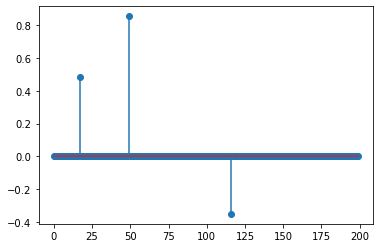

Time for 2000 iterations: 11.36399507522583 seconds
Final f(x)+g(x): 1.190011156953309
Subdifferential: 0.9975571317746178


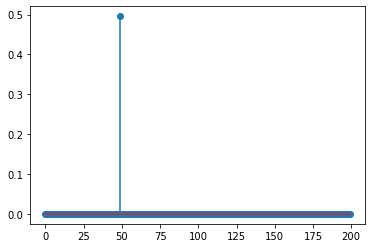

Time for 2000 iterations: 11.522950649261475 seconds
Final f(x)+g(x): 0.7186897238002903
Subdifferential: 0.9999999996016437


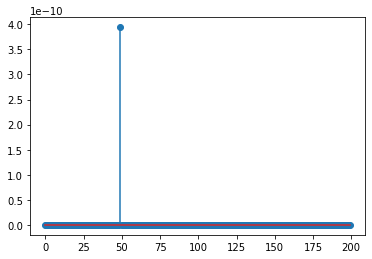

Text(0.5, 1.0, 'Stepsize')

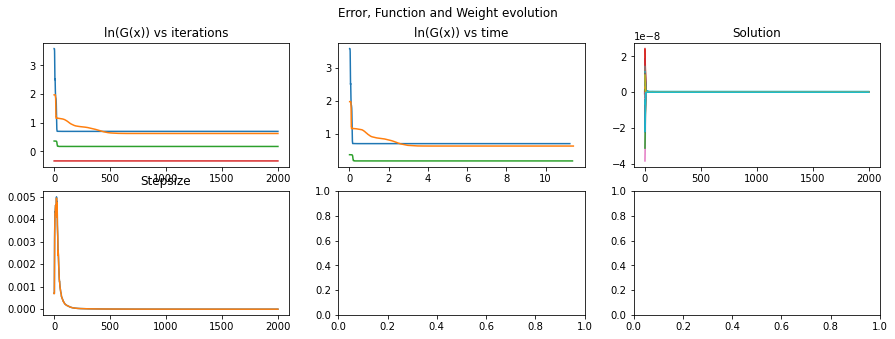

In [81]:
#Do stochastic gradient descent with step chosen using Barzilai-Borwein (SGD-BB in the paper)
step = 0.001
niter = 2000
xtemp = np.zeros((samples,niter))
funcvec_sgd_bb = np.zeros((lamsz,niter))
steparr = np.zeros((2,niter))
uold = u
vold = v
epoch_sz = features
epoch_u = 0
epoch_v = 0
beta = 10/(features)
time_sgd_bb = np.zeros((lamsz,niter))
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    uold = u
    vold = v
    epoch_u = 0
    epoch_v = 0
    start = time.time()
    for i in range(niter):
        phik = 1 + i
    
        if(i > 1):
            Ckm1u = SGD_BB_k(u,uold,gradu_avg,gradu_avg_old,Ckm1u,phik,i,epoch_sz)
            Ckm1v = SGD_BB_k(v,vold,gradv_avg,gradv_avg_old,Ckm1v,phik,i,epoch_sz)
            stepu = Ckm1u / phik
            stepv = Ckm1v / phik
            #stepu = (1/epoch_sz) * BBstep(u,uold,gradu_avg,gradu_avg_old)
            #stepv = (1/epoch_sz) * BBstep(v,vold,gradv_avg,gradv_avg_old)
            steparr[0,i] = stepu
            steparr[1,i] = stepv
    
        uold = u
        vold = v
        if (i <= 1):
            Ckm1u = 1
            Ckm1v = 1
            stepu = .1/np.linalg.norm(A)
            stepv = .1/np.linalg.norm(A)
            steparr[0,i] = stepu
            steparr[1,i] = stepv
            gradu_avg = 0
            gradv_avg = 0
        gradu_avg_old = gradu_avg
        gradv_avg_old = gradv_avg
        gradu_avg = 0
        gradv_avg = 0
        for t in range(epoch_sz):
            rndindx = np.random.randint(0, features)
            gradu = SGnabU(u,v,A,y,lam,rndindx)
            gradv = SGnabV(u,v,A,y,lam,rndindx)
            u = u - stepu * gradu
            v = v - stepv * gradv
            gradu_avg = beta * gradu + (1-beta) * gradu_avg
            gradv_avg = beta * gradv + (1-beta) * gradv_avg
    
        xtemp[:,i] = u * v
        funcvec_sgd_bb[l,i] = funcreg(A,(u * v),y,lam)
        time_sgd_bb[l,i] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_sgd_bb[l,-1])
    print("Subdifferential:", SubdifTest(A,u * v,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(time_sgd_bb[0,:],np.log(funcvec_sgd_bb[0,:].T));
axs3[0,1].plot(time_sgd_bb[1,:],np.log(funcvec_sgd_bb[1,:].T));
axs3[0,1].plot(time_sgd_bb[2,:],np.log(funcvec_sgd_bb[2,:].T));
axs3[0,1].set_title('ln(G(x)) vs time')
axs3[0,0].plot(np.log(funcvec_sgd_bb.T));
axs3[0,0].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

# SVRG-BB



<ipython-input-8-ed84ca6b916a>:3: RuntimeWarning: overflow encountered in matmul
  fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
<ipython-input-67-42b4b4dc4382>:45: RuntimeWarning: overflow encountered in multiply
  x = u * v
<ipython-input-8-ed84ca6b916a>:2: RuntimeWarning: invalid value encountered in matmul
  dif = A@x - y
<ipython-input-26-fdcb03f5c9f8>:4: RuntimeWarning: overflow encountered in multiply
  Li = Xi @ (u*v) - y[indx]
<ipython-input-26-fdcb03f5c9f8>:4: RuntimeWarning: invalid value encountered in matmul
  Li = Xi @ (u*v) - y[indx]
<ipython-input-26-fdcb03f5c9f8>:5: RuntimeWarning: overflow encountered in multiply
  return u + (1/lam)*features*v*(Xi @ (u*v) - y[indx])*Xi.T
<ipython-input-26-fdcb03f5c9f8>:5: RuntimeWarning: invalid value encountered in matmul
  return u + (1/lam)*features*v*(Xi @ (u*v) - y[indx])*Xi.T


Time for 25 iterations: 0.6881103515625 seconds
Final f(x)+g(x): nan
Subdifferential: nan


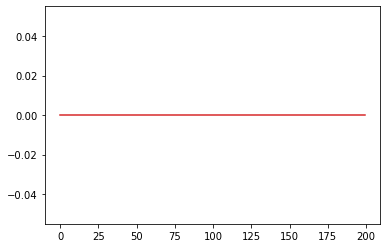

Time for 25 iterations: 0.9360687732696533 seconds
Final f(x)+g(x): 1.8692291454980665
Subdifferential: 1.0000000000017792


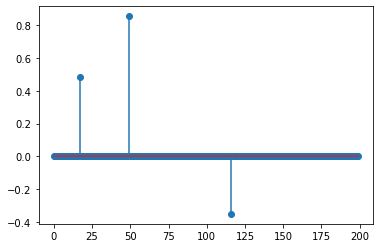

Time for 25 iterations: 0.861649751663208 seconds
Final f(x)+g(x): 1.190009680865903
Subdifferential: 1.000000362272875


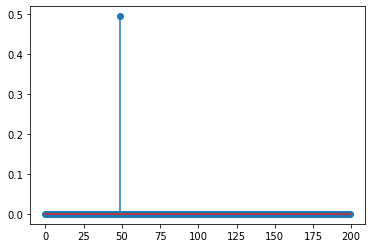

Time for 25 iterations: 0.6940488815307617 seconds
Final f(x)+g(x): 0.7186897238002905
Subdifferential: 0.9999999877322308


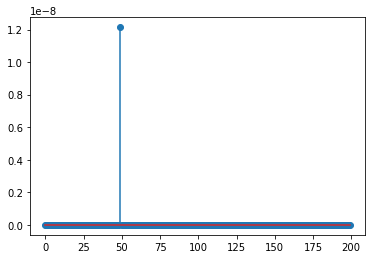

Text(0.5, 1.0, 'Stepsize')

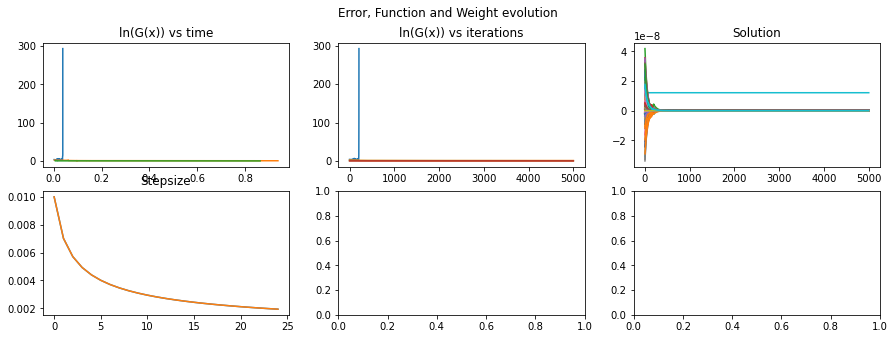

In [67]:
#Do SVRG with decreasing stepsize
step = 0.001
niter = 25
xtemp3 = np.zeros((samples,niter))
epoch_sz = 2*features
funcvec_svr = np.zeros((lamsz,niter*epoch_sz))
steparr = np.zeros((2,niter))
xtemp3 = np.zeros((samples,niter*epoch_sz))
time_svr = np.zeros((lamsz,niter*epoch_sz))
start = time.time()
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    start = time.time()
    for i in range(niter):
        gradu_rl = GnabU(u,v,A,y,lam)
        gradv_rl = GnabV(u,v,A,y,lam)
        stepu = 0.01/(1+i)**0.51
        stepv = 0.01/(1+i)**0.51
        #stepu = 0.01/(1+i)**0.1
        #stepv = 0.01/(1+i)**0.1
        steparr[0,i] = stepu
        steparr[1,i] = stepv
        x = u * v
        #xtemp3[:,i] = x
        #funcvec3[i] = funcreg(A,x,y,lam)
        u0 = u
        v0 = v
        #utemp = np.zeros((samples,epoch_sz))
        #vtemp = np.zeros((samples,epoch_sz))
        for j in range(epoch_sz):
            rndindx = np.random.randint(features)
            gradu = SGnabU(u,v,A,y,lam,rndindx)
            gradv = SGnabV(u,v,A,y,lam,rndindx)
            gradu0 = SGnabU(u0,v0,A,y,lam,rndindx)
            gradv0 = SGnabV(u0,v0,A,y,lam,rndindx)
            u = u - stepu*(gradu_rl + gradu - gradu0)
            v = v - stepv*(gradv_rl + gradv - gradv0)
            #utemp[:,j] = u
            #vtemp[:,j] = v
            #epchindx = np.random.randint(epoch_sz)
            #u = utemp[:,epchindx]
            #v = vtemp[:,epchindx]
            x = u * v
            xtemp3[:,i*epoch_sz+j] = x
            funcvec_svr[l,i*epoch_sz+j] = funcreg(A,x,y,lam)
            time_svr[l,i*epoch_sz+j] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_svr[l,-1])
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_svr[0,:],np.log(funcvec_svr[0,:].T));
axs3[0,0].plot(time_svr[1,:],np.log(funcvec_svr[1,:].T));
axs3[0,0].plot(time_svr[2,:],np.log(funcvec_svr[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_svr.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

Time for 15 iterations: 0.4220247268676758 seconds
Final f(x)+g(x): 2.011378643108675
Subdifferential: 1.0426635042424455


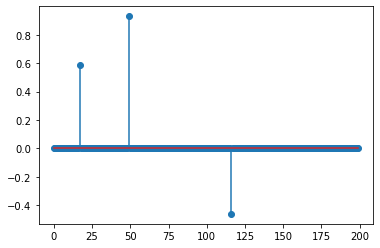

Time for 15 iterations: 0.5830249786376953 seconds
Final f(x)+g(x): 1.8692335457412932
Subdifferential: 1.0058876372127583


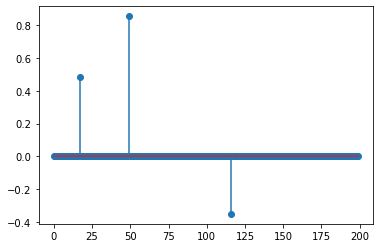

Time for 15 iterations: 0.5100345611572266 seconds
Final f(x)+g(x): 1.1900096852557167
Subdifferential: 1.0001360052342265


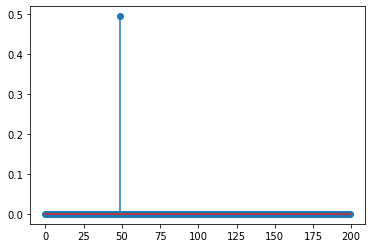

Time for 15 iterations: 0.4440314769744873 seconds
Final f(x)+g(x): 0.7186897238002903
Subdifferential: 0.9999999997545933


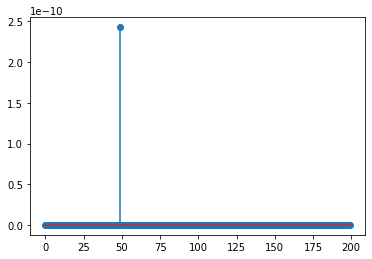

Text(0.5, 1.0, 'Stepsize')

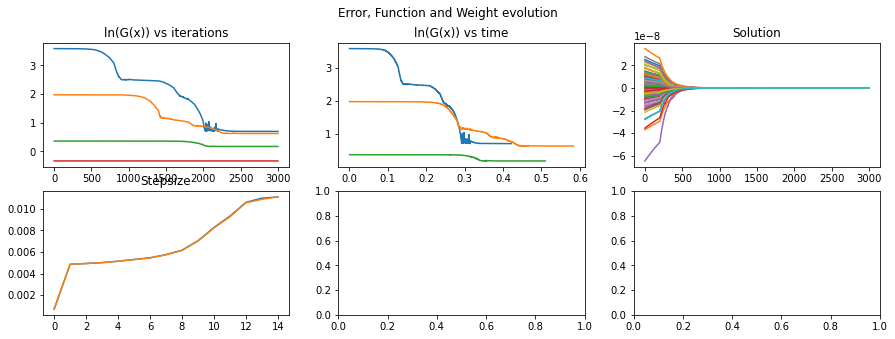

In [69]:
#Do SVRG-BB
step = 0.001
niter = 15
epoch_sz = 2*features
xtemp = np.zeros((samples,niter*epoch_sz))
funcvec_svr_bb = np.zeros((lamsz,niter*epoch_sz))
steparr = np.zeros((2,niter))
uold = u
vold = v
epoch_u = 0
epoch_v = 0
beta = 10/(features)
gradu_rl = GnabU(u,v,A,y,lam)
gradv_rl = GnabV(u,v,A,y,lam)
time_svr_bb = np.zeros((lamsz,niter*epoch_sz))
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    uold = u
    vold = v
    epoch_u = 0
    epoch_v = 0
    gradu_rl = GnabU(u,v,A,y,lam)
    gradv_rl = GnabV(u,v,A,y,lam)
    start = time.time()
    for i in range(niter):
        gradu_rl_old = gradu_rl
        gradv_rl_old = gradv_rl
        gradu_rl = GnabU(u,v,A,y,lam)
        gradv_rl = GnabV(u,v,A,y,lam)
    
        if(i > 0):
            stepu = (1/epoch_sz) * BBstep(u,uold,gradu_rl,gradu_rl_old)
            stepv = (1/epoch_sz) * BBstep(v,vold,gradv_rl,gradv_rl_old)
            steparr[0,i] = stepu
            steparr[1,i] = stepv
    
        uold = u
        vold = v
        if (i == 0):
            stepu = .1/np.linalg.norm(A)
            stepv = .1/np.linalg.norm(A)
            steparr[0,i] = stepu
            steparr[1,i] = stepv

        for t in range(epoch_sz):
            rndindx = np.random.randint(features)
            gradu = SGnabU(u,v,A,y,lam,rndindx)
            gradv = SGnabV(u,v,A,y,lam,rndindx)
            gradu0 = SGnabU(uold,vold,A,y,lam,rndindx)
            gradv0 = SGnabV(uold,vold,A,y,lam,rndindx)
            u = u - stepu*(gradu_rl + gradu - gradu0)
            v = v - stepv*(gradv_rl + gradv - gradv0)
            x = u * v
            xtemp[:,i*epoch_sz+t] = x
            funcvec_svr_bb[l,i*epoch_sz+t] = funcreg(A,x,y,lam)
            time_svr_bb[l,i*epoch_sz+t] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_svr_bb[l,-1])
    print("Subdifferential:", SubdifTest(A,u * v,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(time_svr_bb[0,:],np.log(funcvec_svr_bb[0,:].T));
axs3[0,1].plot(time_svr_bb[1,:],np.log(funcvec_svr_bb[1,:].T));
axs3[0,1].plot(time_svr_bb[2,:],np.log(funcvec_svr_bb[2,:].T));
axs3[0,1].set_title('ln(G(x)) vs time')
axs3[0,0].plot(np.log(funcvec_svr_bb.T));
axs3[0,0].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [33]:
def LineSearchSU(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for u minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = SGnabU(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

<ipython-input-16-bd4994221600>:3: RuntimeWarning: overflow encountered in matmul
  return (v.T @ v)/2 + (u.T @ u)/2 + (1/lam)*(dif.T @ dif)
<ipython-input-19-c9be083c57c2>:6: RuntimeWarning: overflow encountered in matmul
  t = -c * grad.T @ grad
<ipython-input-25-fb0770917de3>:5: RuntimeWarning: overflow encountered in multiply
  return v + (1/lam)*features*u*(Xi @ (u*v) - y[indx])*Xi.T
<ipython-input-19-c9be083c57c2>:7: RuntimeWarning: invalid value encountered in double_scalars
  while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
<ipython-input-17-9aef3fe1557b>:2: RuntimeWarning: overflow encountered in multiply
  return v + (1/lam)*u*((X.T @ X)@(v*u) - X.T @ y)
<ipython-input-16-bd4994221600>:2: RuntimeWarning: invalid value encountered in matmul
  dif = X@(u * v) - y
<ipython-input-26-fdcb03f5c9f8>:4: RuntimeWarning: invalid value encountered in matmul
  Li = Xi @ (u*v) - y[indx]
<ipython-input-26-fdcb03f5c9f8>:5: RuntimeWarning: invalid value encountered in matmul


Time for 2000 iterations: 13.914180040359497 seconds
Final f(x)+g(x): nan
Subdifferential: nan


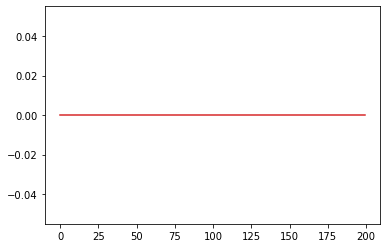

Time for 2000 iterations: 2.075674533843994 seconds
Final f(x)+g(x): 4.6731938571098395
Subdifferential: 1.4097205832250441


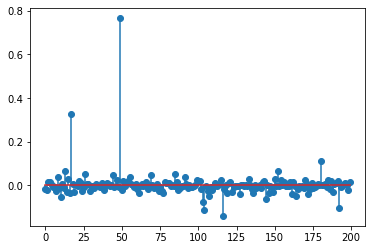

Time for 2000 iterations: 2.076859474182129 seconds
Final f(x)+g(x): 5.694302383914815
Subdifferential: 1.1145625455923291


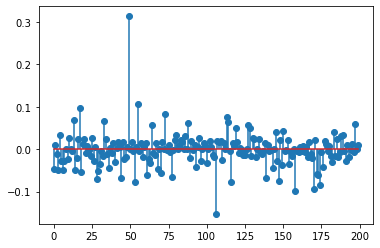

Time for 2000 iterations: 2.041905641555786 seconds
Final f(x)+g(x): 6.389295209339579
Subdifferential: 0.8143897847639411


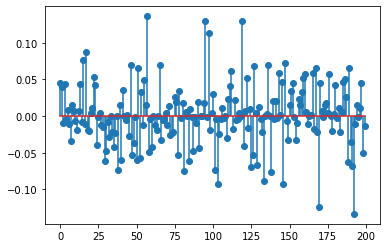

Text(0.5, 1.0, 'Stepsize')

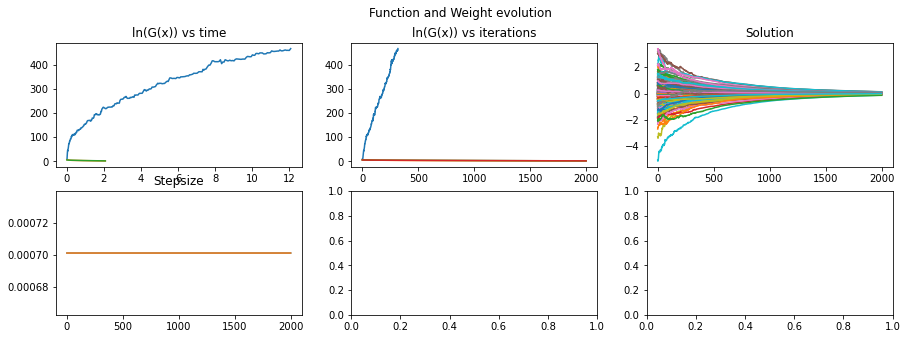

In [83]:
#Do stochastic gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 2000
xtemp3 = np.zeros((samples,niter))
funcvec_sgd_ar = np.zeros((lamsz,niter))
steparr = np.zeros((2,niter))
time_sgd_ar = np.zeros((lamsz,niter))
for l in range(lamsz):
    u = np.random.randn(samples)
    v = np.random.randn(samples)
    lam = lamb[l]
    start = time.time()
    for i in range(niter):
        rndindx = np.random.randint(0, features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        stepu = LineSearchU(u,v,A,y,lam)
        stepv = LineSearchV(u,v,A,y,lam)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
        u = u - stepu*gradu
        v = v - stepv*gradv
        x = u * v
        xtemp3[:,i] = x
        funcvec_sgd_ar[l,i] = funcreg(A,x,y,lam)
        time_sgd_ar[l,i] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds') 
    print("Final f(x)+g(x):", funcvec_sgd_ar[l,-1])
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(x)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs3[0,0].plot(time_sgd_ar[0,:],np.log(funcvec_sgd_ar[0,:].T));
axs3[0,0].plot(time_sgd_ar[1,:],np.log(funcvec_sgd_ar[1,:].T));
axs3[0,0].plot(time_sgd_ar[2,:],np.log(funcvec_sgd_ar[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_sgd_ar.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

# Stochastic Forward-Backward

We modify the F-B algorithm to work with SGD, rather than batch descent.

We have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla_{i} f(x_n)\right).$$
That is,
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{m} \sum_{j=1}^m g_j\right),$$
where
$$\mathbb{E} \left(g_j \right) = \nabla f(x_n)$$
and
$$ g_j = \frac{1}{\lambda}L_i \cdot A_i^T,$$
with $prox, L_i, A_i$ as above.

In [35]:
def SGnabX(X,x,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    Li = Xi @ x - y[indx]
    features = np.size(X,0)
    return features*Li*Xi.T

Time for 5000 iterations: 0.47553062438964844 seconds
Final f(x)+g(x): 2.15111915127419
Subdifferential: 2.2737065115062824


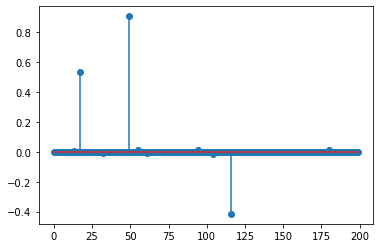

Time for 5000 iterations: 0.4840128421783447 seconds
Final f(x)+g(x): 1.911507005377442
Subdifferential: 1.0543844425049425


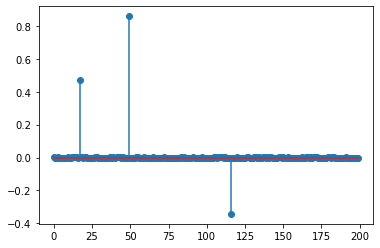

Time for 5000 iterations: 0.5250368118286133 seconds
Final f(x)+g(x): 1.3916689805515827
Subdifferential: 0.9708563864606035


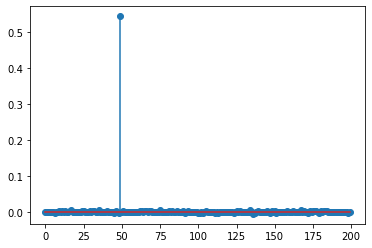

Time for 5000 iterations: 0.5991358757019043 seconds
Final f(x)+g(x): 0.7217058275098207
Subdifferential: 0.9679246787891359


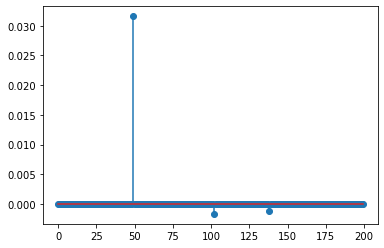

Text(0.5, 1.0, 'Solution')

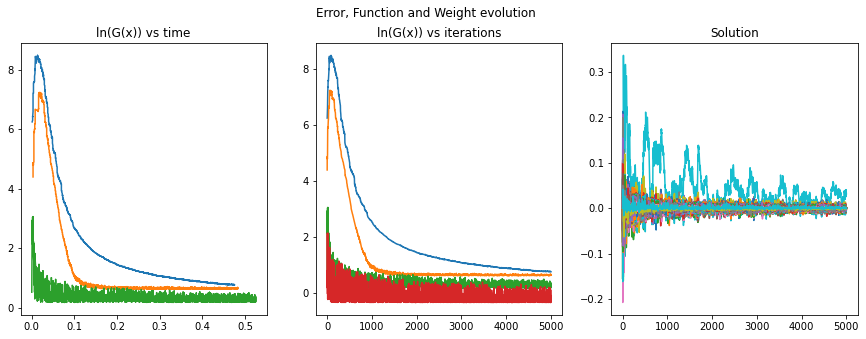

In [90]:
#Implement SGD Forward Backward alg
#initialize x_0 = 0
#x = np.random.randn(samples)
niter = 5000
xtemp = np.zeros((samples,niter))
funcvec_fb_sgd = np.zeros((lamsz,niter))
omg = .1/np.linalg.norm(A)
omgk = omg
time_fb_sgd = np.zeros((lamsz,niter))
#mbs = round(features*0.8)        #minibatch size
for l in range(lamsz):
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    x = u*v;
    lam = lamb[l]
    start = time.time()
    for i in range(niter):
        grad = np.zeros(samples)
        rndindx = np.random.randint(features)
        #for j in range(mbs):          #Iterate over minibatch
        #    rndindx = np.random.randint(0, features)
        #    grad = grad + SGnabX(A,x,y,lam,rndindx)
    
        #grad = (1/mbs)*grad              #<---  It seems dividing by the batch size causes the algorithm to perform worse.
        grad = SGnabX(A,x,y,lam,rndindx)
        omgk = 0.001/(1+i)**0.51
        x = prox(x - omgk*grad,omgk*lam)
        xtemp[:,i] = x
        funcvec_fb_sgd[l,i] = funcreg(A,x,y,lam)
        time_fb_sgd[l,i] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds') 
    print("Final f(x)+g(x):", funcvec_fb_sgd[l,-1])
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(x)
    plt.show()

fig, axs4 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs4[0].plot(time_fb_sgd[0,:],np.log(funcvec_fb_sgd[0,:].T));
axs4[0].plot(time_fb_sgd[1,:],np.log(funcvec_fb_sgd[1,:].T));
axs4[0].plot(time_fb_sgd[2,:],np.log(funcvec_fb_sgd[2,:].T));
axs4[0].set_title('ln(G(x)) vs time')
axs4[1].plot(np.log(funcvec_fb_sgd.T));
axs4[1].set_title('ln(G(x)) vs iterations')
axs4[2].plot(xtemp.T);
axs4[2].set_title('Solution')


# Dual Averaging Method

In [37]:
def RDAstep(gt,t,lam,rho,gamma):
    lRDA = lam + rho/np.sqrt(t)
    x = np.zeros(np.size(gt))
    for i in range(np.size(gt)):
        if abs(gt[i]) <= lRDA:
            x[i] = 0
        else:
            x[i] = (-np.sqrt(t) / gamma) * (gt[i] - lRDA*np.sign(gt[i]))
            
    return x

Time for 5000 iterations: 3.852515935897827 seconds
Final f(x)+g(x): 5.825732737697809
Subdifferential: 11.033621066265354


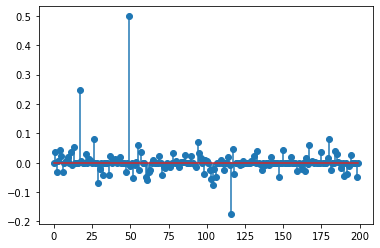

Time for 5000 iterations: 1.5126230716705322 seconds
Final f(x)+g(x): 2.385033413560568
Subdifferential: 3.2987445534749287


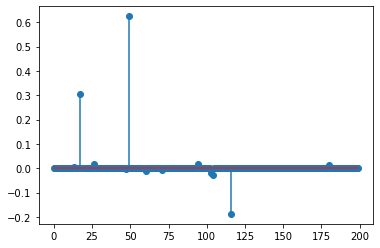

Time for 5000 iterations: 0.9497182369232178 seconds
Final f(x)+g(x): 1.2006848095203924
Subdifferential: 1.2068432619973732


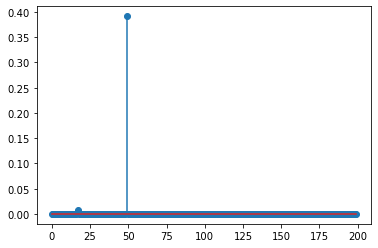

Time for 5000 iterations: 0.9080626964569092 seconds
Final f(x)+g(x): 0.7187717961349327
Subdifferential: 0.987120171334129


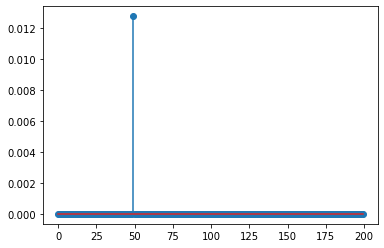

<ipython-input-92-527d7de97687>:34: RuntimeWarning: divide by zero encountered in log
  axs5[0].plot(time_rda[0,:],np.log(funcvec_rda[0,:].T));
<ipython-input-92-527d7de97687>:35: RuntimeWarning: divide by zero encountered in log
  axs5[0].plot(time_rda[1,:],np.log(funcvec_rda[1,:].T));
<ipython-input-92-527d7de97687>:36: RuntimeWarning: divide by zero encountered in log
  axs5[0].plot(time_rda[2,:],np.log(funcvec_rda[2,:].T));
<ipython-input-92-527d7de97687>:40: RuntimeWarning: divide by zero encountered in log
  axs5[1].plot(np.log(funcvec_rda.T));


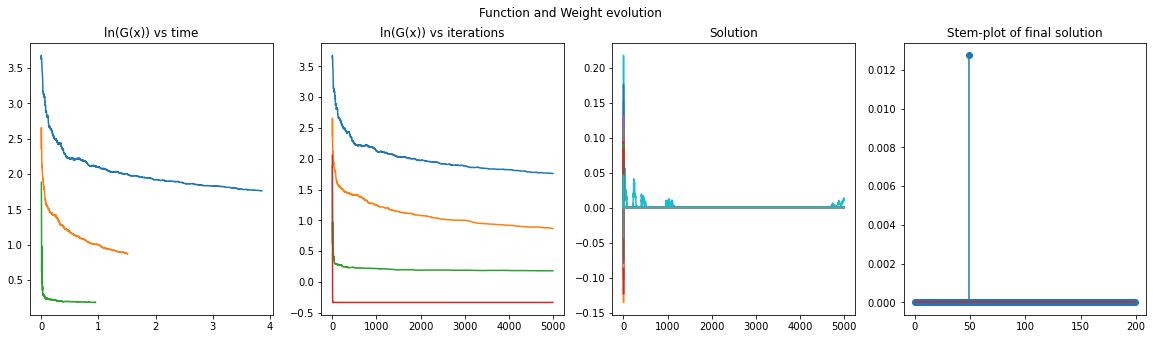

In [92]:
#Incorporate the RDA method as defined in paper by Lin Xiao
niter = 5000
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec_rda = np.zeros((lamsz,niter))
omg = .1/np.linalg.norm(A)
rho = 0.001
gamma = 5000
time_rda = np.zeros((lamsz,niter))
#mbs = round(features*0.8)        #minibatch size
for l in range(lamsz):
    lam = lamb[l]
    x = np.zeros(samples)
    gt = np.zeros(samples)
    gtavg = np.zeros(samples)
    start = time.time()
    for i in range(1,niter):
        rndindx = np.random.randint(features)
        gt = SGnabX(A,x,y,lam,rndindx)    
        gtavg = ((i-1)/i) * gtavg + (1/i) * gt
        x = RDAstep(gtavg,i,lam,rho,gamma)
        xtemp[:,i] = x
        funcvec_rda[l,i] = funcreg(A,x,y,lam)
        time_rda[l,i] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_rda[l,-1])
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(x)
    plt.show()

fig, axs5 = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Function and Weight evolution')
axs5[0].plot(time_rda[0,:],np.log(funcvec_rda[0,:].T));
axs5[0].plot(time_rda[1,:],np.log(funcvec_rda[1,:].T));
axs5[0].plot(time_rda[2,:],np.log(funcvec_rda[2,:].T));
axs5[0].set_title('ln(G(x)) vs time')
axs5[2].plot(xtemp.T);
axs5[2].set_title('Solution')
axs5[1].plot(np.log(funcvec_rda.T));
axs5[1].set_title('ln(G(x)) vs iterations')
axs5[3].stem(x);
axs5[3].set_title('Stem-plot of final solution')
plt.savefig('foo2.png')

Time for 5000 iterations: 2.8451948165893555 seconds
Final f(x)+g(x): 5.512347155546531
Subdifferential: 10.565984577505576


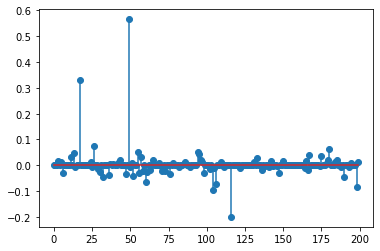

Time for 5000 iterations: 2.830805778503418 seconds
Final f(x)+g(x): 2.6628284418865755
Subdifferential: 4.01957554875687


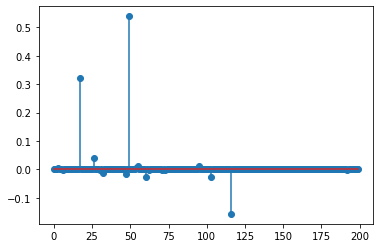

Time for 5000 iterations: 2.752443790435791 seconds
Final f(x)+g(x): 1.437379447600581
Subdifferential: 2.0


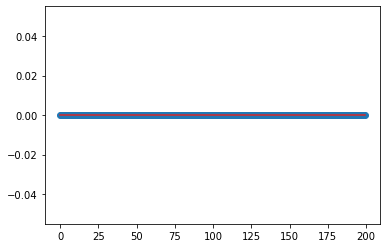

Time for 5000 iterations: 2.7469162940979004 seconds
Final f(x)+g(x): 0.7186897238002905
Subdifferential: 1.0


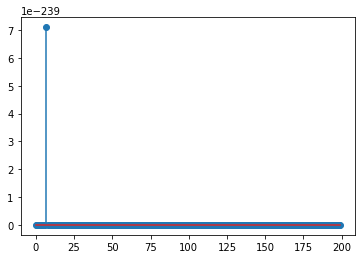

Text(0.5, 1.0, 'Solution')

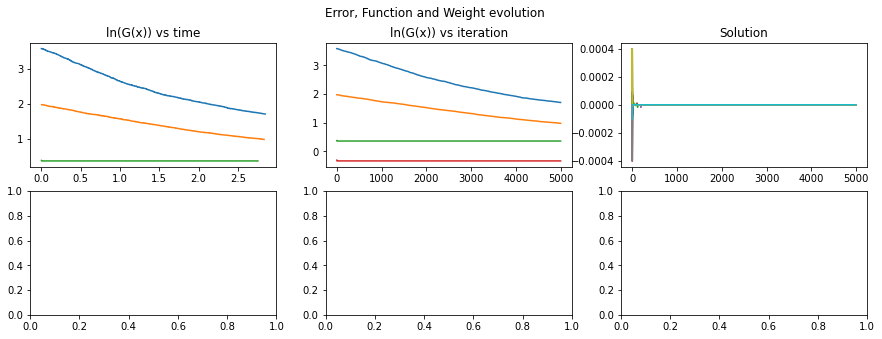

In [93]:
#Do ADAGRAD
step = 0.01
niter = 5000
xtemp3 = np.zeros((samples,niter))
funcvec_adgrd = np.zeros((lamsz,niter))
#beta = 0.95
#steparr = np.zeros((2,niter))
omg = 0.01
eps = 10**(-8) * np.ones(samples) * 0
#eps = np.zeros(samples)
time_adgrd = np.zeros((lamsz,niter))
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    diagradu = np.zeros(samples)
    diagradv = np.zeros(samples)
    start = time.time()
    for i in range(niter):
        rndindx = np.random.randint(features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        for j in range(samples):
            diagradu[j] = diagradu[j] + (gradu[j])**2
            diagradv[j] = diagradv[j] + (gradv[j])**2
        stepu = omg / np.sqrt(diagradu + eps)
        stepv = omg / np.sqrt(diagradv + eps)
        #steparr[0,i] = stepu
        #steparr[1,i] = stepv
        u = u - stepu * gradu
        v = v - stepv * gradv
        x = u * v
        xtemp3[:,i] = x
        funcvec_adgrd[l,i] = funcreg(A,x,y,lam)
        #print(stepu)
        time_adgrd[l,i] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_adgrd[l,-1])
    #print("Final soln:", x)
    #print("Original soln:", x0)
    #print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_adgrd[0,:],np.log(funcvec_adgrd[0,:].T));
axs3[0,0].plot(time_adgrd[1,:],np.log(funcvec_adgrd[1,:].T));
axs3[0,0].plot(time_adgrd[2,:],np.log(funcvec_adgrd[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_adgrd.T));
axs3[0,1].set_title('ln(G(x)) vs iteration')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

In [41]:
#Create quasi-newton step
def qn_step(H,grad):
    n = np.size(grad)
    step = np.zeros(n)
    for i in range(n):
        step[i] = grad[i]/(2*H[i,i])
    return step

Time for 5000 iterations: 12.157509803771973 seconds
Final f(x)+g(x): 2.012235922962306
Subdifferential: 1.0000389882793383


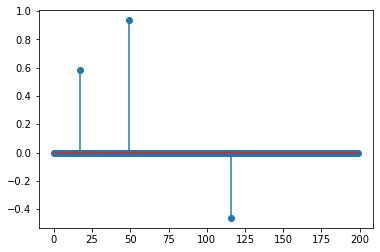

Time for 5000 iterations: 11.222795248031616 seconds
Final f(x)+g(x): 1.871939879448571
Subdifferential: 1.2291965947155308


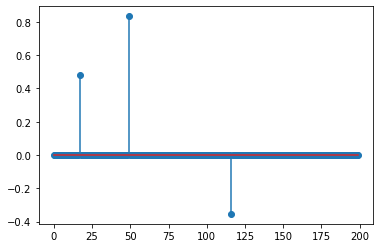

Time for 5000 iterations: 11.33151912689209 seconds
Final f(x)+g(x): 1.1992191274809834
Subdifferential: 0.9749539483180621


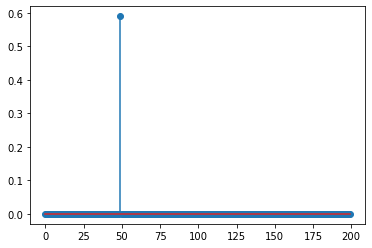

Time for 5000 iterations: 10.986955404281616 seconds
Final f(x)+g(x): 0.7186897238002903
Subdifferential: 0.9999999980084624


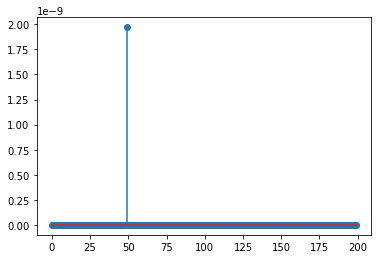

Text(0.5, 1.0, 'Solution')

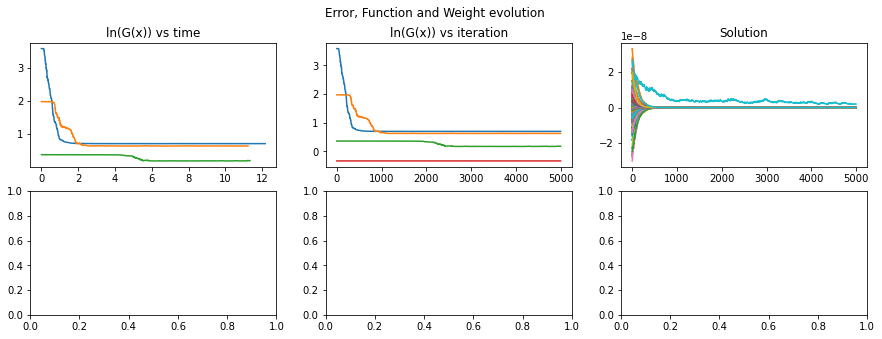

In [94]:
#Do Quasi-Newton using diagonal approximation for Hessian (similar to ADAGRAD)
step = 0.01
niter = 5000
xtemp3 = np.zeros((samples,niter))
funcvec_qn = np.zeros((lamsz,niter))
omg = 0.01
time_qn = np.zeros((lamsz,niter))
AtA = A.T @ A
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    start = time.time()
    for i in range(niter):
        rndindx = np.random.randint(features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        Hu = np.eye(samples) + (1/lam) * np.dot(np.dot(np.diag(v),AtA),np.diag(v))       #These two blocks form the diagonal of Hessian
        Hv = np.eye(samples) + (1/lam) * np.dot(np.dot(np.diag(u),AtA),np.diag(u))
        u = u - omg * qn_step(Hu,gradu)
        v = v - omg * qn_step(Hv,gradv)
        x = u * v
        xtemp3[:,i] = x
        funcvec_qn[l,i] = funcreg(A,x,y,lam)
        time_qn[l,i] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_qn[l,-1])
    #print("Final soln:", x)
    #print("Original soln:", x0)
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_qn[0,:],np.log(funcvec_qn[0,:].T));
axs3[0,0].plot(time_qn[1,:],np.log(funcvec_qn[1,:].T));
axs3[0,0].plot(time_qn[2,:],np.log(funcvec_qn[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_qn.T));
axs3[0,1].set_title('ln(G(x)) vs iteration')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

Time for 5000 iterations: 7.583261728286743 seconds
Final f(x)+g(x): 2.0136671956951453
Subdifferential: 1.3265740624470548


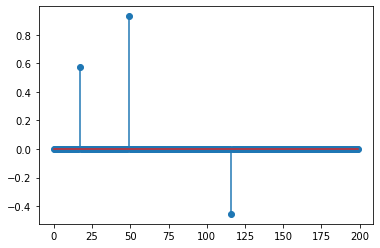

Time for 5000 iterations: 7.130512475967407 seconds
Final f(x)+g(x): 1.8729058353144314
Subdifferential: 0.9829813495259776


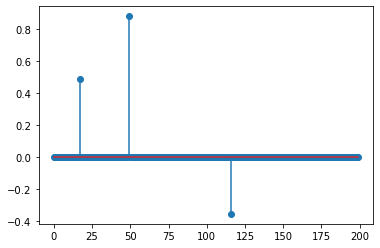

Time for 5000 iterations: 7.033939838409424 seconds
Final f(x)+g(x): 1.437379447600581
Subdifferential: 2.0


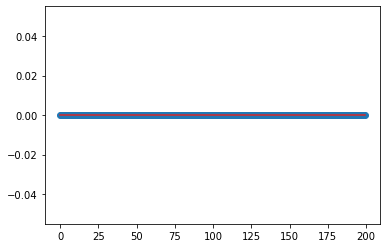

Time for 5000 iterations: 7.224832534790039 seconds
Final f(x)+g(x): 0.7186897238002905
Subdifferential: 1.0


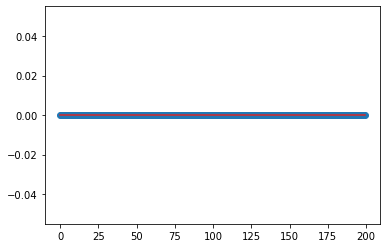

Text(0.5, 1.0, 'Solution')

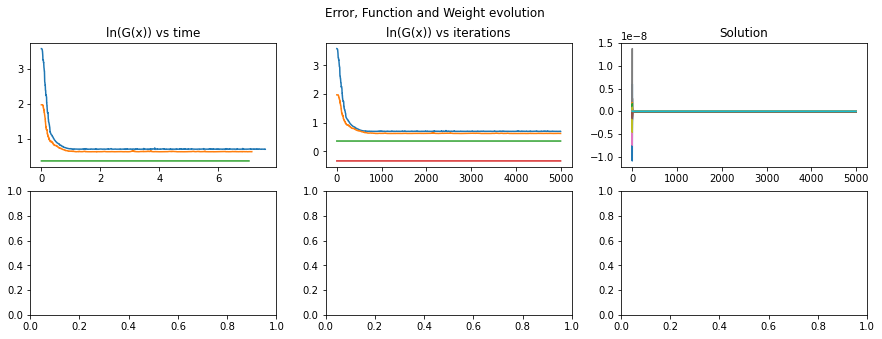

In [95]:
#Do ADADELTA
step = 0.01
niter = 5000
xtemp3 = np.zeros((samples,niter))
funcvec_addta = np.zeros((lamsz,niter))
beta = 0.95
#steparr = np.zeros((2,niter))
omg = 0.01
eps = 10**(-6) * np.ones(samples)
#eps = np.zeros(samples)
time_addta = np.zeros((lamsz,niter))
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    diagradu = np.zeros(samples)
    diagradv = np.zeros(samples)
    rmsu = np.zeros(samples)
    rmsv = np.zeros(samples)
    start = time.time()
    for i in range(niter):
        rndindx = np.random.randint(features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        for j in range(samples):
            diagradu[j] = beta*diagradu[j] + (1-beta)*(gradu[j])**2
            diagradv[j] = beta*diagradv[j] + (1-beta)*(gradv[j])**2
        stepu = np.sqrt(rmsu + eps) / np.sqrt(diagradu + eps)
        stepv = np.sqrt(rmsv + eps) / np.sqrt(diagradv + eps)
        #steparr[0,i] = stepu
        #steparr[1,i] = stepv
        stepgradu = stepu * gradu
        stepgradv = stepv * gradv
        u = u - stepgradu
        v = v - stepgradv
        for j in range(samples):
            rmsu[j] = beta*rmsu[j] + (1-beta)*(stepgradu[j])**2
            rmsv[j] = beta*rmsv[j] + (1-beta)*(stepgradv[j])**2
        x = u * v
        xtemp3[:,i] = x
        funcvec_addta[l,i] = funcreg(A,x,y,lam)
        time_addta[l,i] = time.time() - start
        #print(stepu)
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_addta[l,-1])
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_addta[0,:],np.log(funcvec_addta[0,:].T));
axs3[0,0].plot(time_addta[1,:],np.log(funcvec_addta[1,:].T));
axs3[0,0].plot(time_addta[2,:],np.log(funcvec_addta[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_addta.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

Time for 5000 iterations: 6.732696056365967 seconds
Final f(x)+g(x): 2.0400139913678235
Subdifferential: 1.0074522478959165


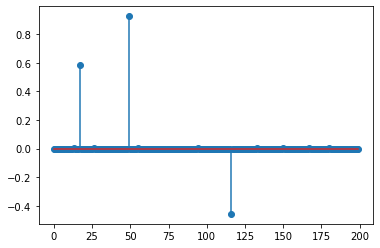

Time for 5000 iterations: 7.000543117523193 seconds
Final f(x)+g(x): 1.8702127731349005
Subdifferential: 1.0316965443815524


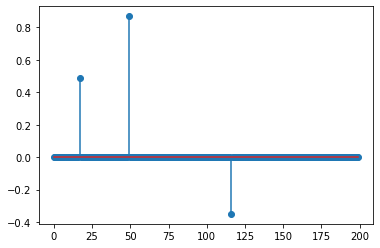

Time for 5000 iterations: 6.935712814331055 seconds
Final f(x)+g(x): 1.1900243255606768
Subdifferential: 0.9948688453854259


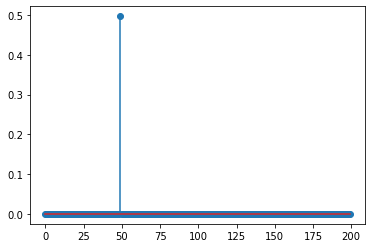

Time for 5000 iterations: 6.502806901931763 seconds
Final f(x)+g(x): 0.7186912926631152
Subdifferential: 0.9999999243973179


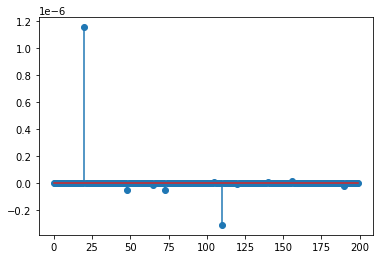

<ipython-input-79-3f1a4874df75>:54: RuntimeWarning: divide by zero encountered in log
  axs3[0,0].plot(time_adam[0,:],np.log(funcvec_adam[0,:].T));
<ipython-input-79-3f1a4874df75>:55: RuntimeWarning: divide by zero encountered in log
  axs3[0,0].plot(time_adam[1,:],np.log(funcvec_adam[1,:].T));
<ipython-input-79-3f1a4874df75>:56: RuntimeWarning: divide by zero encountered in log
  axs3[0,0].plot(time_adam[2,:],np.log(funcvec_adam[2,:].T));
<ipython-input-79-3f1a4874df75>:58: RuntimeWarning: divide by zero encountered in log
  axs3[0,1].plot(np.log(funcvec_adam.T));


Text(0.5, 1.0, 'Solution')

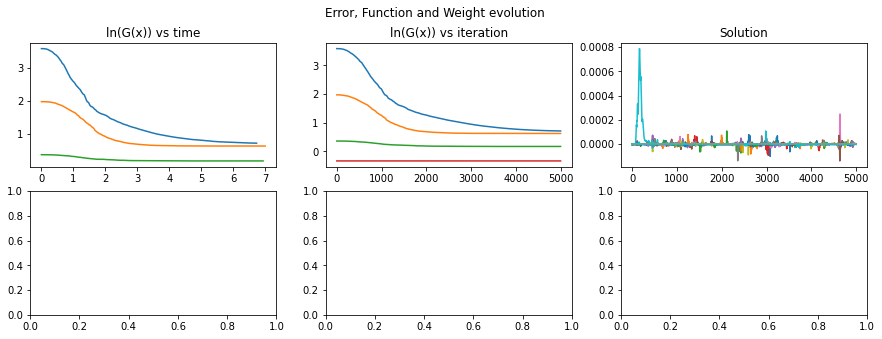

In [79]:
#Do ADAM
step = 0.01
niter = 5000
xtemp3 = np.zeros((samples,niter))
funcvec_adam = np.zeros((lamsz,niter))
beta = 0.9        #Bias term for second moment estimate
beta2 = 0.999     #Bias term for first moment estimate
omg = 0.001        #Stepsize
eps = 10**(-8) * np.ones(samples)
time_adam = np.zeros((lamsz,niter))
for l in range(lamsz):
    lam = lamb[l]
    u = np.random.randn(samples)*0.0001
    v = np.random.randn(samples)*0.0001
    diagrad1u = np.zeros(samples)      #Initialize first moment estimate for u
    diagrad1v = np.zeros(samples)      #Initialize first moment estimate for v
    diagrad2u = np.zeros(samples)       #Initialize second moment estimate for u
    diagrad2v = np.zeros(samples)       #Initialize second moment estimate for v
    start = time.time()
    for i in range(1,niter):
        rndindx = np.random.randint(features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        for j in range(samples):
            diagrad1u[j] = beta*diagrad1u[j] + (1-beta)*(gradu[j])
            diagrad1v[j] = beta*diagrad1v[j] + (1-beta)*(gradv[j])
            diagrad2u[j] = beta2*diagrad2u[j] + (1-beta2)*(gradu[j])**2
            diagrad2v[j] = beta2*diagrad2v[j] + (1-beta2)*(gradv[j])**2
        
        
        if (i > 0):                                      #Implement bias correction
            diagrad1u_b = diagrad1u / (1 - beta**i)
            diagrad1v_b = diagrad1v / (1 - beta**i)
            diagrad2u_b = diagrad2u / (1 - beta2**i)
            diagrad2v_b = diagrad2v / (1 - beta2**i)
        
        stepu = omg * diagrad1u_b / (np.sqrt(diagrad2u_b) + eps)
        stepv = omg * diagrad1v_b / (np.sqrt(diagrad2v_b) + eps)
        u = u - stepu
        v = v - stepv
        x = u * v
        xtemp3[:,i] = x
        funcvec_adam[l,i] = funcreg(A,x,y,lam)
        time_adam[l,i] = time.time() - start
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_adam[l,-1])
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_adam[0,:],np.log(funcvec_adam[0,:].T));
axs3[0,0].plot(time_adam[1,:],np.log(funcvec_adam[1,:].T));
axs3[0,0].plot(time_adam[2,:],np.log(funcvec_adam[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_adam.T));
axs3[0,1].set_title('ln(G(x)) vs iteration')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

Time for 5000 iterations: 0.6840648651123047 seconds
Final f(x)+g(x): 35.93448619001452
Subdifferential: 49.99999999999999


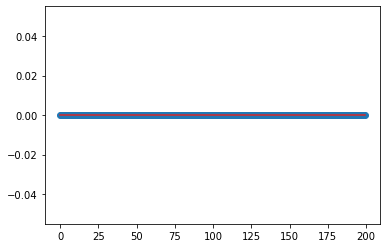

Time for 5000 iterations: 0.8760614395141602 seconds
Final f(x)+g(x): 7.1868972380029055
Subdifferential: 10.0


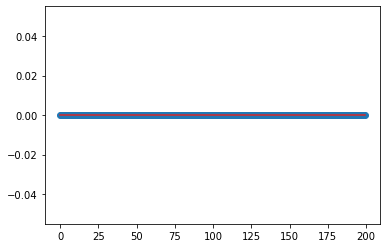

Time for 5000 iterations: 0.6990492343902588 seconds
Final f(x)+g(x): 1.437379447600581
Subdifferential: 2.0


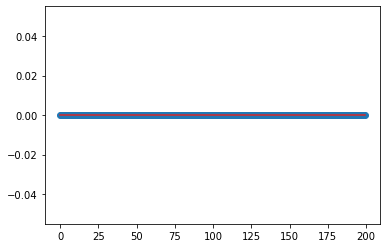

Time for 5000 iterations: 0.6690459251403809 seconds
Final f(x)+g(x): 0.7186897238002905
Subdifferential: 1.0


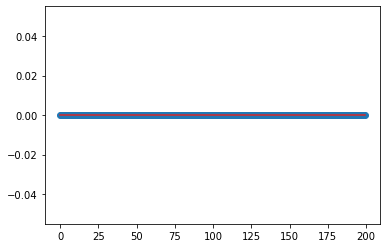

Text(0.5, 1.0, 'Stepsize')

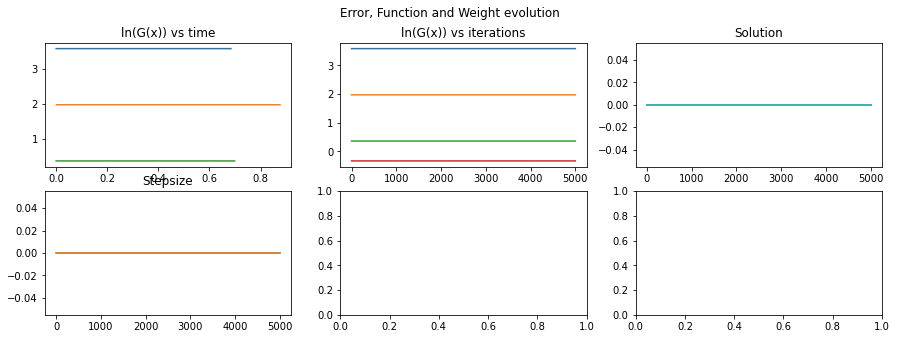

In [117]:
#Implement SAG with decaying stepsize omg_k = omg_0 / (1 + k/10)
step = 0.001
niter = 5000
xtemp3 = np.zeros((samples,niter))
funcvec_sag = np.zeros((lamsz,niter))
time_sag = np.zeros((lamsz,niter))
steparr = np.zeros((2,niter))
#bound = y.T @ y + 8 * (features**3) * ((np.max(y))**3) * (np.max(A)**2) + (y.T @ (A @ A.T) @ y)
for l in range(lamsz):
    #u = np.random.randn(samples)*0.0001
    #v = np.random.randn(samples)*0.0001
    u = np.zeros(samples)
    v = np.zeros(samples)
    du = np.zeros(samples)
    dv = np.zeros(samples)
    yu = np.zeros(samples)
    yv = np.zeros(samples)
    lam = lamb[l]
    #alpha = 1 / (bound / lam)
    alpha = 0.00001
    start = time.time()
    for i in range(niter):
        rndindx = np.random.randint(features)
        du = du - yu + SGnabU(u,v,A,y,lam,rndindx)
        dv = dv - yv + SGnabV(u,v,A,y,lam,rndindx)
        yu = SGnabU(u,v,A,y,lam,rndindx)
        yv = SGnabU(u,v,A,y,lam,rndindx)
        #ch_sample = A[:,rndindx].reshape(-1,1)
        #stepu = 0.01/(1+i)**0.51
        #stepv = 0.01/(1+i)**0.51
        #steparr[0,i] = stepu
        #steparr[1,i] = stepv
        u = u - alpha*du
        v = v - alpha*dv
        x = u * v
        xtemp3[:,i] = x
        funcvec_sag[l,i] = funcreg(A,x,y,lam)
        #print(stepu)
        time_sag[l,i] = time.time() - start
    
    end = time.time()
    print('Time for', niter, 'iterations:', end - start, 'seconds')
    print("Final f(x)+g(x):", funcvec_sag[l,-1])
    print("Subdifferential:", SubdifTest(A,x,y,lam))
    plt.stem(u*v)
    plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(time_sag[0,:],np.log(funcvec_sag[0,:].T));
axs3[0,0].plot(time_sag[1,:],np.log(funcvec_sag[1,:].T));
axs3[0,0].plot(time_sag[2,:],np.log(funcvec_sag[2,:].T));
axs3[0,0].set_title('ln(G(x)) vs time')
axs3[0,1].plot(np.log(funcvec_sag.T));
axs3[0,1].set_title('ln(G(x)) vs iterations')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

<ipython-input-126-e2544b459842>:10: RuntimeWarning: divide by zero encountered in log
  axsf[i].plot(np.log(funcvec_rda[i,:].T),label='RDA');
<ipython-input-126-e2544b459842>:13: RuntimeWarning: divide by zero encountered in log
  axsf[i].plot(np.log(funcvec_adam[i,:].T),label='ADAM');
<ipython-input-126-e2544b459842>:22: RuntimeWarning: divide by zero encountered in log
  axsf[i].plot(np.log(funcvec_rda[i,:].T),label='RDA');
<ipython-input-126-e2544b459842>:25: RuntimeWarning: divide by zero encountered in log
  axsf[i].plot(np.log(funcvec_adam[i,:].T),label='ADAM');
<ipython-input-126-e2544b459842>:34: RuntimeWarning: divide by zero encountered in log
  axsf[i].plot(np.log(funcvec_rda[i,0:3000].T),label='RDA');
<ipython-input-126-e2544b459842>:37: RuntimeWarning: divide by zero encountered in log
  axsf[i].plot(np.log(funcvec_adam[i,0:3000].T),label='ADAM');
<ipython-input-126-e2544b459842>:46: RuntimeWarning: divide by zero encountered in log
  axsf[i].plot(np.log(funcvec_rda[i,0:1

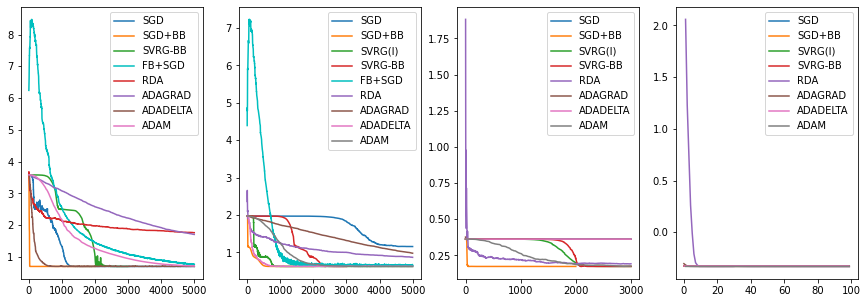

In [126]:
fig, axsf = plt.subplots(1,lamsz, figsize=(15,5))
#fig.suptitle('ln(G(x)) vs iteration for lambda = |A^Ty|/k, for k = 50, 10, 2, 1, respectively')
for i in range(lamsz):
    if (i == 0):
        axsf[i].plot(np.log(funcvec_sgd[i,:].T),label='SGD');
        axsf[i].plot(np.log(funcvec_sgd_bb[i,:].T),label='SGD+BB');
        #axsf[i].plot(np.log(funcvec_svr[i,:].T),label='SVRG(I)');
        axsf[i].plot(np.log(funcvec_svr_bb[i,:].T),label='SVRG-BB');
        axsf[i].plot(np.log(funcvec_fb_sgd[i,:].T), 'c-' ,label='FB+SGD');
        axsf[i].plot(np.log(funcvec_rda[i,:].T),label='RDA');
        axsf[i].plot(np.log(funcvec_adgrd[i,:].T),label='ADAGRAD');
        axsf[i].plot(np.log(funcvec_addta[i,:].T),label='ADADELTA');
        axsf[i].plot(np.log(funcvec_adam[i,:].T),label='ADAM');
        axsf[i].legend()
    
    elif (i == 1):
        axsf[i].plot(np.log(funcvec_sgd[i,:].T),label='SGD');
        axsf[i].plot(np.log(funcvec_sgd_bb[i,:].T),label='SGD+BB');
        axsf[i].plot(np.log(funcvec_svr[i,:].T),label='SVRG(I)');
        axsf[i].plot(np.log(funcvec_svr_bb[i,:].T),label='SVRG-BB');
        axsf[i].plot(np.log(funcvec_fb_sgd[i,:].T), 'c-' ,label='FB+SGD');
        axsf[i].plot(np.log(funcvec_rda[i,:].T),label='RDA');
        axsf[i].plot(np.log(funcvec_adgrd[i,:].T),label='ADAGRAD');
        axsf[i].plot(np.log(funcvec_addta[i,:].T),label='ADADELTA');
        axsf[i].plot(np.log(funcvec_adam[i,:].T),label='ADAM');
        axsf[i].legend()
        
    elif (i == 2):
        axsf[i].plot(np.log(funcvec_sgd[i,0:3000].T),label='SGD');
        axsf[i].plot(np.log(funcvec_sgd_bb[i,0:3000].T),label='SGD+BB');
        axsf[i].plot(np.log(funcvec_svr[i,0:3000].T),label='SVRG(I)');
        axsf[i].plot(np.log(funcvec_svr_bb[i,:].T),label='SVRG-BB');
        #axsf[i].plot(np.log(funcvec_fb_sgd[i,:].T),label='FB+SGD');
        axsf[i].plot(np.log(funcvec_rda[i,0:3000].T),label='RDA');
        axsf[i].plot(np.log(funcvec_adgrd[i,0:3000].T),label='ADAGRAD');
        axsf[i].plot(np.log(funcvec_addta[i,0:3000].T),label='ADADELTA');
        axsf[i].plot(np.log(funcvec_adam[i,0:3000].T),label='ADAM');
        axsf[i].legend()
        
    elif (i == 3):
        axsf[i].plot(np.log(funcvec_sgd[i,0:100].T),label='SGD');
        axsf[i].plot(np.log(funcvec_sgd_bb[i,0:100].T),label='SGD+BB');
        axsf[i].plot(np.log(funcvec_svr[i,0:100].T),label='SVRG(I)');
        axsf[i].plot(np.log(funcvec_svr_bb[i,0:100].T),label='SVRG-BB');
        #axsf[i].plot(np.log(funcvec_fb_sgd[i,:].T),label='FB+SGD');
        axsf[i].plot(np.log(funcvec_rda[i,0:100].T),label='RDA');
        axsf[i].plot(np.log(funcvec_adgrd[i,0:100].T),label='ADAGRAD');
        axsf[i].plot(np.log(funcvec_addta[i,0:100].T),label='ADADELTA');
        axsf[i].plot(np.log(funcvec_adam[i,0:100].T),label='ADAM');
        axsf[i].legend()
    #axsf[i].set_title('ln(G(x)) vs iteration')
    
fig.savefig('funcvec2.png', bbox_inches='tight')
fig.savefig('funcvec2.svg', format='svg', dpi=1200)
fig.savefig('funcvec2.eps', format='eps', dpi=1200)

In [73]:
def ADGRDstep_temp(gt,t,lam,step):
    x = np.zeros(np.size(gt))
    for i in range(np.size(gt)):
        if abs(gt[i]) <= lam:
            x[i] = 0
        else:
            x[i] = step[i]**t * (gt[i] - lam*np.sign(gt[i]))
            
    return x

In [74]:
def ADGRDstep(t,lam,step,u):
    x = np.zeros(np.size(u))
    for i in range(np.size(u)):
        x[i] = np.sign(-u[i]) * step[i]**t * max(abs(u[i] / t) - lam,0)
            
    return x

Final f(x)+g(x): 14.04844618364119
Final soln: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.
  0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.
  0.  0. -0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.
 -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.
  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Subdifferential: 10.0


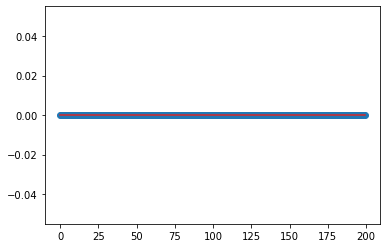

<ipython-input-75-f19be62d63be>:44: RuntimeWarning: divide by zero encountered in log
  axs5[1].plot(np.log(funcvec.T));


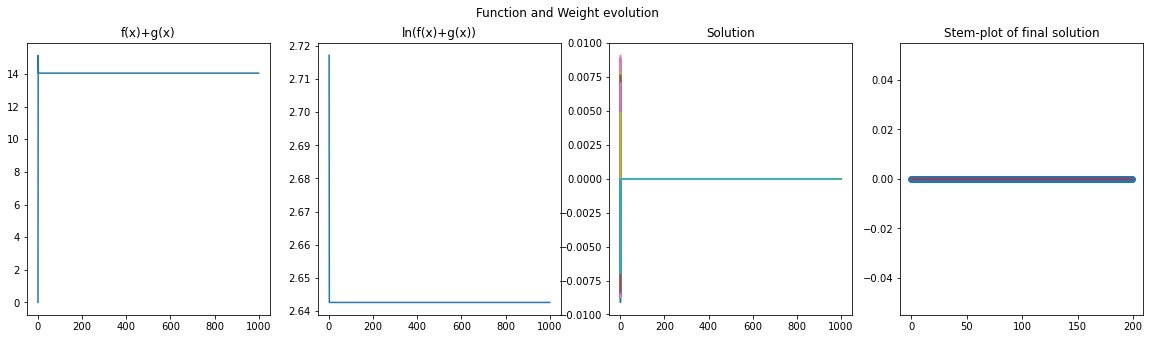

In [75]:
#Incorporate the L1-ADAGRAD method
#This isn't working yet
#x = np.random.randn(samples)*0.0001
x = np.zeros(samples)
gt = np.zeros(samples)
niter = 1000
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
#omg = .1/np.linalg.norm(A)
omg = 0.01
rho = 0.005
gamma = 5000
gtavg = np.zeros(samples)
diagrad = np.zeros(samples)
eps = 10**(-8) * np.ones(samples)
u = np.zeros(samples)

for i in range(1,niter):
    rndindx = np.random.randint(features)
    gt = SGnabX(A,x,y,lam,rndindx)  
    gtavg = ((i-1)/i) * gtavg + (1/i) * gt
    u = i * gtavg
    for j in range(samples):
        diagrad[j] = diagrad[j] + (gt[j])**2
    step = omg / (np.sqrt(diagrad)+eps)
    x = ADGRDstep_temp(gtavg,i,lam,step)
    #x = ADGRDstep(i,lam,step,u)
    xtemp[:,i] = x
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs5 = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Function and Weight evolution')
axs5[0].plot(funcvec.T);
axs5[0].set_title('f(x)+g(x)')
axs5[2].plot(xtemp.T);
axs5[2].set_title('Solution')
axs5[1].plot(np.log(funcvec.T));
axs5[1].set_title('ln(f(x)+g(x))')
axs5[3].stem(x);
axs5[3].set_title('Stem-plot of final solution')
plt.savefig('foo2.png')

In [108]:
np.max(np.array([[1,2,3],[4,5,6],[7,8,9]]))

9

In [110]:
bound

4762799342.784912